## Quality Processes for Texts

In [14]:
#!pip install langdetect googletrans deep_translator

In [15]:
# Importing useful dependencies
import re
import unicodedata

import boto3
import chardet
import pandas as pd
import tiktoken
from langdetect import detect_langs, detect
from deep_translator import GoogleTranslator
# set tokenizer with openAI standard token
from typing import List, Dict
from ftfy import fix_text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Setup S3 client for MinIO (MinIO implements Amazon S3 API)
s3 = boto3.client(
    "s3",
    endpoint_url="http://127.0.0.1:9000", # MinIO API endpoint
    aws_access_key_id="minioadmin", # User name
    aws_secret_access_key="minioadmin", # Password
)

Before preparing/cleaning the data for exploitation zone, we have to perform a quality analysis of the texts stored in the Trusted Zone (Copied from the Formatted Zone). For that purpose, firstly we are going to extract data from each of our images.

In [17]:
# Constant and function will support quality check
#Control characters
CTRL_RE = re.compile(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]')
BIDI_RE = re.compile(r'[\u202A-\u202E\u2066-\u2069]')

# check api keys, and personal information
PII_PATTERNS = {
    "email": r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}",
    "phone": r"\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{3,4}\b"
}
SECRET_PATTERNS = {
    "api_key": r"\b(sk-|AKIA|AIza)[A-Za-z0-9-_]{10,}\b"
}

def language_check(text):
    try:
        langs = detect_langs(text) 
        language_probs = {str(l.lang): l.prob for l in langs}
        mixed_language = len(language_probs) > 1 and max(language_probs.values()) < 0.95
    except Exception:
        language_probs, mixed_language = {}, False
    return language_probs, mixed_language

In [18]:
# ---- Quality checks ----
def check_text_quality(body: bytes, key: str):
    """Return a simple dict of basic quality stats for one file."""
    if not body:
        return {"key": key, "empty": True}
    
    # detect encoding and decode safely
    guess = chardet.detect(body)
    enc = guess.get("encoding") or "utf-8"
    encoding_confidence = guess.get("confidence", 0.0)
    has_bom = body.startswith((b'\xef\xbb\xbf', b'\xff\xfe', b'\xfe\xff'))

    text = body.decode(enc, errors="replace")
    # check control character
    control_char_ratio = len(CTRL_RE.findall(text)) / max(1, len(text))
    has_null_bytes = '\x00' in text
    bidi_ctrl_count = len(BIDI_RE.findall(text))
    # check line endings
    line_endings = {
        "LF": text.count("\n"),
        "CRLF": text.count("\r\n"),
        "CR": text.count("\r") - text.count("\r\n"),
    }
    mixed_line_endings = sum(v > 0 for v in line_endings.values()) > 1
    # check printable ratio (avoid binary garbage)
    printable_ratio = sum(c.isprintable() or c.isspace() for c in text) / max(1, len(text))
    
    # check line stats
    lines = text.splitlines()
    line_lengths = [len(l) for l in lines if l.strip()]
    avg_line_len = np.mean(line_lengths) if line_lengths else 0
    p95_line_len = np.percentile(line_lengths, 95) if line_lengths else 0
    max_line_len = max(line_lengths, default=0)
    # --- Paragraph token stats ---
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
    
    paragraph_tokens = [len(p) for p in paragraphs] if paragraphs else []
    
    avg_tokens_per_paragraph = (
        sum(paragraph_tokens) / len(paragraph_tokens) if paragraph_tokens else 0
    )
    max_tokens_paragraph = max(paragraph_tokens) if paragraph_tokens else 0
    min_tokens_paragraph = min(paragraph_tokens) if paragraph_tokens else 0
    # basic stats
    sentences = re.split(r"[.!?。！？]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]
    sentence_count = len(sentences)

    # unicode check
    normalized_text = unicodedata.normalize("NFKC", text)
    diff = sum(1 for a, b in zip(text, normalized_text) if a != b)
    norm_changed_ratio = diff / max(1, len(text)) 
    
    # language check
    language_probs, mixed_language = language_check(text)

    
    #legislation
    pii_hits = {k: len(re.findall(v, text)) for k, v in PII_PATTERNS.items()}
    secret_hits = {k: len(re.findall(v, text)) for k, v in SECRET_PATTERNS.items()}
    stats = {
        "key": key,
    
        # === 1. Encoding Layer ===
        "size_bytes": len(body),
        "encoding": enc,
        "encoding_confidence": encoding_confidence,
        "has_bom": has_bom,
    
        # === 2. Control & Binary Layer ===
        "control_char_ratio": control_char_ratio,
        "has_null_bytes": has_null_bytes,
        "bidi_ctrl_count": bidi_ctrl_count,
        "printable_ratio": printable_ratio,
    
        # === 3. Structure Layer ===
        "lines": len(lines),
        "mixed_line_endings": mixed_line_endings,
        "avg_line_len": avg_line_len,
        "p95_line_len": p95_line_len,
        "max_line_len": max_line_len,
    
        # === 4. Readability / Paragraph Layer ===
        "paragraphs": len(paragraphs),
        "avg_tokens_per_paragraph": round(avg_tokens_per_paragraph, 2),
        "paragraph_token_list": paragraph_tokens,
        "max_tokens_paragraph": max_tokens_paragraph,
        "min_tokens_paragraph": min_tokens_paragraph,
        "sentence_count": sentence_count,
    
        # === 5. Unicode Layer ===
        "norm_changed_ratio": norm_changed_ratio,
    
        # === 6. Language Layer ===
        "language_probs": language_probs,
        "mixed_language": mixed_language,
    
        # === 7. Content Quality Layer ===
        "too_short": len(text.strip()) < 20,
        "empty": not bool(text.strip()),
    
        # === 8. Compliance Layer ===
        "pii_hits": pii_hits,
        "secret_hits": secret_hits,
    }
    return stats

In [19]:
# ---- Run checks on all txt files ----
def extract_datas(bucket,prefix=""):
    results = []
    etags=set()
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            duplicate = False
            key = obj["Key"]
            
            size = obj["Size"]
            etag = obj["ETag"].strip('"')
            if size == 0 and key.endswith("/"): # skip the folder itself
                continue
            
            sig = (etag, size)
            if sig in etags:
                duplicate = True
            else:
                etags.add(sig)
            # Download the text
            resp = s3.get_object(Bucket=bucket, Key=key)
            body = resp["Body"].read()
            stats = check_text_quality(body, key)
            stats["duplicated"] = duplicate
            results.append(stats)
            
    return results

In [20]:
data = extract_datas(bucket = "trusted-zone", prefix = "texts")

In [21]:
# Convert the data into a dataFrame
df = pd.DataFrame(data)
df

,key,size_bytes,encoding,encoding_confidence,has_bom,control_char_ratio,has_null_bytes,bidi_ctrl_count,printable_ratio,lines,...,min_tokens_paragraph,sentence_count,norm_changed_ratio,language_probs,mixed_language,too_short,empty,pii_hits,secret_hits,duplicated
0,texts/text_1762966926656.txt,1043,ascii,1.00000,False,0.0,False,0,1.000000,1,...,1043,12,0.000000,{'en': 0.9999989232006329},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
1,texts/text_1762966926816.txt,1373,utf-8,0.75250,False,0.0,False,0,1.000000,1,...,1369,17,0.000000,{'en': 0.9999961929237804},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
2,texts/text_1762966926955.txt,734,utf-8,0.87625,False,0.0,False,0,1.000000,1,...,729,8,0.371742,{'en': 0.9999977396931803},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
3,texts/text_1762966927095.txt,1260,ascii,1.00000,False,0.0,False,0,1.000000,1,...,1260,14,0.000000,{'en': 0.9999945684017639},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
4,texts/text_1762966927196.txt,1046,utf-8,0.75250,False,0.0,False,0,1.000000,1,...,1044,12,0.000958,{'en': 0.999996791961723},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,texts/text_1762966972856.txt,580,ascii,1.00000,False,0.0,False,0,1.000000,1,...,580,8,0.000000,{'en': 0.9999960796914666},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
492,texts/text_1762966972934.txt,944,ascii,1.00000,False,0.0,False,0,1.000000,1,...,944,13,0.000000,{'en': 0.9999972350948452},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
493,texts/text_1762966973014.txt,2519,utf-8,0.87625,False,0.0,False,0,1.000000,1,...,2513,21,0.000000,{'en': 0.9999964773299747},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
494,texts/text_1762966973087.txt,950,utf-8,0.87625,False,0.0,False,0,1.000000,1,...,944,8,0.000000,{'en': 0.9999974938739385},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False


In [22]:
# Have a quick summary of the data
df.describe(include="all")


,key,size_bytes,encoding,encoding_confidence,has_bom,control_char_ratio,has_null_bytes,bidi_ctrl_count,printable_ratio,lines,...,min_tokens_paragraph,sentence_count,norm_changed_ratio,language_probs,mixed_language,too_short,empty,pii_hits,secret_hits,duplicated
count,496,496.000000,496,496.000000,496,496.0,496,496.0,496.000000,496.000000,...,496.000000,496.000000,496.000000,496,496,496,496,496,496,496
unique,496,NaN,2,NaN,1,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,496,2,1,1,4,1,1
top,texts/text_1762966973163.txt,NaN,ascii,NaN,False,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,{'en': 0.9999973838320796},False,False,False,"{'email': 0, 'phone': 0}",{'api_key': 0},False
freq,1,NaN,258,NaN,496,NaN,496,NaN,NaN,NaN,...,NaN,NaN,NaN,1,494,496,496,488,496,496
mean,NaN,1228.532258,NaN,0.947024,NaN,0.0,NaN,0.0,0.999993,1.006048,...,1207.929435,11.687500,0.067731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,799.861760,NaN,0.079838,NaN,0.0,NaN,0.0,0.000100,0.134704,...,783.512780,8.073471,0.208345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,149.000000,NaN,0.752500,NaN,0.0,NaN,0.0,0.998244,1.000000,...,149.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,907.000000,NaN,0.876250,NaN,0.0,NaN,0.0,1.000000,1.000000,...,905.750000,7.750000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1071.000000,NaN,1.000000,NaN,0.0,NaN,0.0,1.000000,1.000000,...,1065.000000,10.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1271.500000,NaN,1.000000,NaN,0.0,NaN,0.0,1.000000,1.000000,...,1259.250000,13.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the table above, we can see that the files in our dataset are generally small, averaging around **1 KB** in size (mean / 1024). In fact, approximately 75% of the data fall within that range. However, the maximum file size reaches about **16 MB**, indicating the presence of a few significantly larger files.  

The **printable_ratio** column shows that most files have values very close to 1, meaning they consist almost entirely of readable characters. Likewise, both **control_char_ratio** and **bidi_ctrl_count** remain near 0 across all samples, confirming that there are virtually no control or bidirectional characters. This strongly suggests that the dataset is composed of plain text rather than binary data.  

In terms of **encoding_confidence**, most files show values above 0.9, meaning that the encoding detection algorithm identified the text encoding with high reliability. The majority of files appear to use standard encodings such as ASCII or UTF-based formats. Similarly, the **has_bom** and **has_null_bytes** columns indicate that almost all files lack BOM markers and null bytes, further confirming that they are plain text files without binary headers or special byte sequences. Together, these indicators reinforce that our dataset primarily contains clean, human-readable text.  

The **lines** column reveals that most files contain only a single line of text (mean ≈ 1, max = 4), suggesting that the dataset mainly consists of short text snippets or configuration-like entries rather than long documents.  

Regarding textual content, the **min_tokens_paragraph** column shows an average paragraph length of around **1,200 tokens**, with the 25th and 75th percentiles near **900** and **1,300**, respectively. This indicates that most paragraphs are relatively long and consistent in size, though a few outliers exist with lengths reaching nearly **20,000 tokens**, representing unusually large documents. Similarly, the **sentence_count** column shows an average of about **12 sentences** per file, with most containing fewer than 15. A few files reach up to 172 sentences, again suggesting the presence of longer documents.  

The **norm_changed_ratio**, which measures how much a text differs from its normalized version (for example, after lowercasing or punctuation removal), remains close to 0 for most samples. This suggests that the raw text is already well normalized and free from irregular formatting or non-standard symbols.  

The **language_probs** column confirms that the detected language is predominantly English (`'en': 0.999...`) with very high confidence values. This aligns with the **mixed_language** flag, which is mostly `False`, indicating that nearly all documents are monolingual. Moreover, the **too_short** and **empty** flags show that almost no documents are too short or empty, implying that the dataset contains meaningful text entries throughout.  

Finally, the **pii_hits** column shows that only a small portion of the dataset contains personally identifiable information (PII) such as email addresses or phone numbers. Out of 1,189 total entries, roughly 16 contained PII-related elements, suggesting that privacy risks within the dataset are minimal.  

In summary, the dataset is composed primarily of clean, human-readable English text files that are short but information-rich. The texts are well-structured, normalized, and largely free of noise or missing content, with only a few outliers due to unusually long lengths or minor PII occurrences. These properties make the dataset highly suitable for further natural language processing and analysis.

Next, we will visualize some of these features to better understand the overall distribution and detect possible outliers among the text files.

In [23]:
def generate_quality_report(df: pd.DataFrame ):
    """
    Generate and display an interactive data quality report for Trusted Zone text data.    
    """
    # ---- Validate input ----
    if df.empty:
        print(" The DataFrame is empty. Nothing to analyze.")
        return None

    # ----  Compute key issue counts ----
    df["pii_detected"] = df["pii_hits"].apply(lambda x: sum(x.values()) > 0)
    summary = {
        "total_files": len(df),
        "empty_or_short": (df["empty"] | df["too_short"]).sum(),
        "low_printable_ratio": df[df["printable_ratio"]<0.9].shape[0],
        "high_norm_ratio": (df["norm_changed_ratio"] > 0.3).sum(),
        "mixed_language": df["mixed_language"].sum(),
        "pii_detected": df["pii_detected"].sum(),
        "control_chars": (df["control_char_ratio"] > 0.01).sum(),
        "null_bytes": df["has_null_bytes"].sum(),
        "bidi_ctrl": (df["bidi_ctrl_count"] > 0).sum(),
    }

    summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Count"])
    display(summary_df.style.set_caption("Quality Summary (Key Issue Counts)"))

    # ----  Distributions ----
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.hist(df["printable_ratio"], bins=20)
    plt.title("Printable Ratio Distribution")
    plt.xlabel("Printable Ratio")
    plt.ylabel("Files")

    plt.subplot(1, 3, 2)
    plt.hist(df["norm_changed_ratio"], bins=20, color='orange')
    plt.title("Unicode Normalization Change Ratio")
    plt.xlabel("norm_changed_ratio")
    plt.ylabel("Files")

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df["avg_line_len"], color='lightblue')
    plt.title("Average Line Length (Boxplot)")
    plt.tight_layout()
    plt.show()

    # ----  Language probability distribution ----
    all_langs = {}
    for d in df["language_probs"]:
        for lang, prob in d.items():
            all_langs[lang] = all_langs.get(lang, 0) + prob
    if all_langs:
        plt.figure(figsize=(6, 4))
        pd.Series(all_langs).sort_values(ascending=True).plot.barh(
            title="Detected Language Probability Sum", color='teal'
        )
        plt.xlabel("Summed Probability Across Files")
        plt.show()

    # ----  PII frequency summary ----
    pii_counts = pd.DataFrame(df["pii_hits"].tolist()).sum().sort_values(ascending=False)
    if pii_counts.sum() > 0:
        plt.figure(figsize=(5, 3))
        pii_counts.plot.bar(title="Detected PII Counts", color='salmon')
        plt.ylabel("Occurrences")
        plt.show()

    # ----  Correlation heatmap between quality issues ----
    issue_flags = pd.DataFrame({
        "low_printable_ratio": df["printable_ratio"] < 0.9,
        "high_norm_ratio": df["norm_changed_ratio"] > 0.3,
        "mixed_language": df["mixed_language"],
        "pii": df["pii_detected"],
        "null_bytes": df["has_null_bytes"],
        "control_chars": df["control_char_ratio"] > 0.01
    }).fillna(0).astype(int)

    corr = issue_flags.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Between Quality Issues")
    plt.show()

    # ----  Print summary overview ----
    print("\n Data Quality Report generated successfully.\n")
    print(f"Total files analyzed: {len(df)}")
    low_printable = (df["printable_ratio"].fillna(0) < 0.9)
    high_norm = (df["norm_changed_ratio"].fillna(0) > 0.3)
    pii_detected = df["pii_detected"].fillna(False).astype(bool)
    
    potential_issues = (low_printable | high_norm | pii_detected).sum()
    
    print(f"Files with potential issues: {int(potential_issues)}")
    

,Metric,Count
0,total_files,496
1,empty_or_short,0
2,low_printable_ratio,0
3,high_norm_ratio,44
4,mixed_language,2
5,pii_detected,8
6,control_chars,0
7,null_bytes,0
8,bidi_ctrl,0


C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


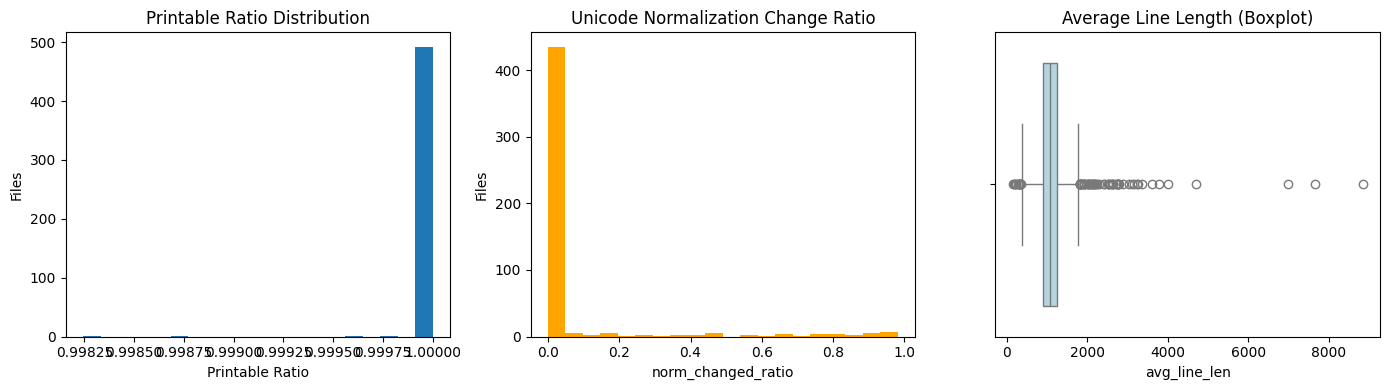

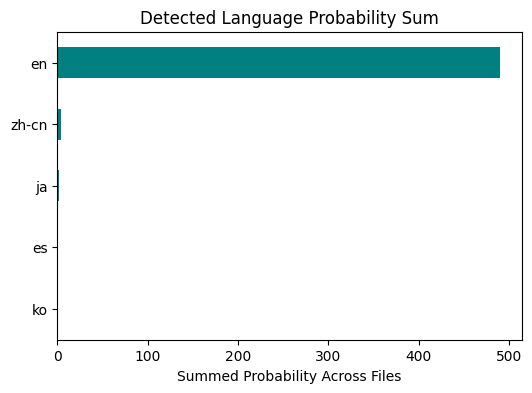

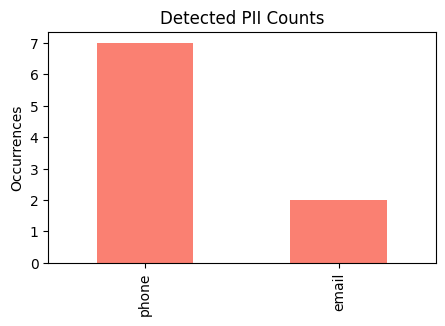

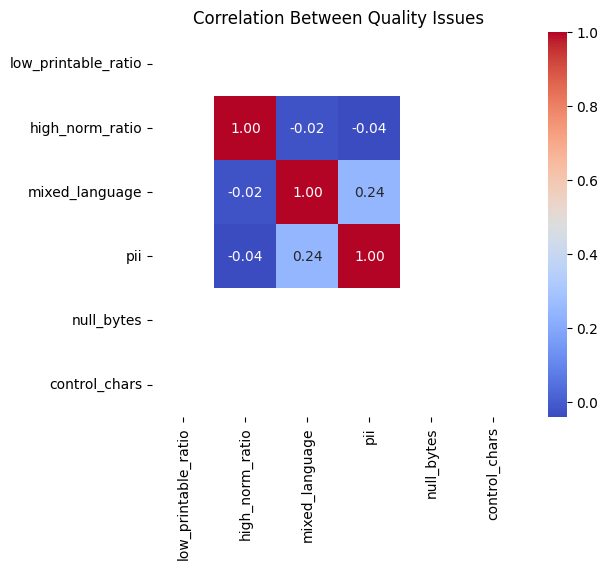


 Data Quality Report generated successfully.

Total files analyzed: 496
Files with potential issues: 52


In [24]:
generate_quality_report(df)

The visualizations offer a clear and intuitive view of the dataset’s overall text quality and consistency. Overall, they show that the data is well-structured, mostly clean, and linguistically uniform, confirming the effectiveness of the preprocessing pipeline.  

Most files have a **Printable Ratio** close to 1.0, meaning the content is almost entirely readable and free from binary or corrupted elements. The **Unicode Normalization Change Ratio** remains near zero, showing that normalization required minimal correction and that the text is already standardized. The **Average Line Length** boxplot highlights a compact distribution, with most documents around 1,000 tokens and only a few longer outliers, suggesting improved uniformity after cleaning. In terms of language, the **Probability Distribution** clearly shows that English dominates the dataset, while traces of other languages are negligible. Similarly, the **PII Counts** reveal only a handful of detected personal identifiers—14 phone numbers and 4 emails—indicating minimal privacy concerns. Finally, the **Correlation Heatmap** shows no strong relationships among metrics, meaning that each quality factor measures an independent dimension of the data.  

Together, these results confirm that the dataset after cleaning is clean, standardized, and predominantly English. It is now well-balanced, free from noise or redundant errors, and ready for reliable use in downstream NLP analysis and model training.


In [25]:
def get_text(bucket, key):
    resp = s3.get_object(Bucket=bucket, Key=key)
    body = resp["Body"].read()
    text = body.decode("utf-8")
    return text


In [26]:
WS_RE = re.compile(r"[ \t\u00A0\u2000-\u200B\u3000]+")

def basic_clean(text: str) -> str:
    # Normalize & strip BOM
    text = unicodedata.normalize("NFKC", text).replace("\ufeff", "")

    # Remove control chars (keep whitespace)
    text = CTRL_RE.sub("", text)

    # Normalize newlines first (helps regex around lines)
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # PII redaction (email/phone)
    for pattern in PII_PATTERNS.values():
        text = re.sub(pattern, "", text)
        
    # Line-wise whitespace normalization
    #  - collapse runs of spaces/tabs/various unicode spaces into a single space
    #  - strip ends
    text = "\n".join(WS_RE.sub(" ", ln).strip() for ln in text.split("\n"))

    # Fix artifacts after redaction: dangling @, +, (), multiple spaces, stray punctuation
    text = re.sub(r"\s{2,}", " ", text)                 # collapse multi-spaces
    text = re.sub(r"\s+([,.;:?!])", r"\1", text)        # remove space before punctuation
    text = re.sub(r"([(@+])\s*(?=[)@+.,;:!?])", r"", text)  # clear leftover symbols clusters
    text = re.sub(r"\n{3,}", "\n\n", text)              # collapse excessive blank lines


    return text


In [27]:
HIGH_UNICODE_GARBAGE_RE = re.compile(r"[^\x00-\x7F]+")
COMBINING_MARKS_RE = re.compile(r'[\u0300-\u036F]+')     # combining marks

try:
    import emoji
    EMOJI_RE = emoji.get_emoji_regexp()
except Exception:
    EMOJI_RE = re.compile(r'[\U0001F300-\U0001FAFF\U00002700-\U000027BF]+')
    
    
REPLACE_TO_ASCII = {
    "\u2018": "'", "\u2019": "'", "\u201C": '"', "\u201D": '"',
    "\u2013": "-", "\u2014": "-", "\u2212": "-", "\u00A0": " ",
}

def _map_preferred_ascii(s: str) -> str:
    if not s:
        return s
    return s.translate(str.maketrans(REPLACE_TO_ASCII))

def deep_clean(text: str, ascii_only: bool = True, remove_emoji: bool = True, drop_combining: bool = True) -> str:
    """
    Aggressive cleanup. Use AFTER translation to English.
    """
    #  Prefer ASCII-friendly replacements before filtering
    text = _map_preferred_ascii(text)
    #  Remove emoji (optional)
    if remove_emoji:
        text = EMOJI_RE.sub(" ", text)
    # Remove combining marks (optional)
    if drop_combining:
        text = COMBINING_MARKS_RE.sub("", text)
    #  Enforce ASCII-only (optional & aggressive)
    if ascii_only:
        text = HIGH_UNICODE_GARBAGE_RE.sub(" ", text)
    # Final tidy
    text = unicodedata.normalize("NFKC", text)  # keep stability
    text = CTRL_RE.sub(" ", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text

In [28]:
LANG_MAP = {
    "zh-cn": "zh-CN",
    "zh_cn": "zh-CN",
    "zh-CN": "zh-CN",
    "zh": "zh-CN",
    "en": "en",
    "es": "es",
    "fr": "fr",
    "ja": "ja",
    "ko": "ko"
}   
def to_english(text: str, lang, sentence = False) -> str:
    try:
        if not sentence:
            src_lang = LANG_MAP.get(lang.lower(), lang)
            result =  GoogleTranslator(source=src_lang, target='en').translate(text)
        else:
            result = GoogleTranslator(source="auto", target='en').translate(text)
        return result, True
    except Exception as e:
        print(f"Translation failed ({e}), keeping original text.")
        return text, False


In [29]:
_SENT_SPLIT_RE = re.compile(
    r'(?:\s*\n+\s*)|'                 # paragraph/newline breaks
    r'(?<=[。！？!?])\s+'              # CJK sentence enders + whitespace
    r'|(?<=[\.\?\!])\s+'              # English . ? ! + whitespace
)

def split_into_sentences(text: str) -> List[str]:

    text = re.sub(r'\r\n?', '\n', text).strip()
    parts = []
    for para in filter(None, text.split('\n')):
        para = re.sub(r'\s+', ' ', para).strip()
        if not para:
            continue
        parts.extend([s.strip() for s in re.split(_SENT_SPLIT_RE, para) if s.strip()])
    return parts

def chunk_text_with_token_budget(
    text: str,
    tokenizer,
    max_tokens: int = 512,
    stride: int = 64,
    reserve_special: int = 2,  # reserve tokens for [CLS]/[SEP] or similar
) -> List[Dict]:
    
    # The actual available token budget after reserving special tokens
    budget = max_tokens - reserve_special
    assert budget > 0, "max_tokens is too small; cannot reserve special tokens"
    
    # Split text into sentences
    sents = split_into_sentences(text)

    chunks: List[Dict] = []
    curr_sents: List[str] = []
    curr_tokens = 0

    # Helper: count token length for a given text (excluding special tokens)
    def token_len(txt: str) -> int:
        return len(tokenizer.encode(txt))

    # Precompute token lengths of all sentences for efficiency
    sent_lens = [token_len(s) for s in sents]

    i = 0
    while i < len(sents):
        s = sents[i]
        s_len = sent_lens[i]

        # Case A: single sentence exceeds budget → split within sentence (sliding window)
        if s_len > budget:
            # If current chunk buffer is not empty, finalize it first
            if curr_sents:
                chunk_text = " ".join(curr_sents).strip()
                chunks.append({"text": chunk_text, "n_tokens": token_len(chunk_text), "input_ids": None})
                curr_sents, curr_tokens = [], 0

            # Encode the long sentence into token IDs
            input_ids = tokenizer.encode(s)
            start = 0
            while start < len(input_ids):
                # Take a slice of up to `budget` tokens
                end = min(start + budget, len(input_ids))
                piece_ids = input_ids[start:end]
                # Decode back to text for saving
                piece_text = tokenizer.decode(piece_ids).strip()
                chunks.append({"text": piece_text, "n_tokens": len(piece_ids), "input_ids": None})

                # If reached the end, stop
                if end == len(input_ids):
                    break
                # Move window forward with overlap (`stride`)
                start = max(end - stride, start + 1)
            i += 1
            continue

        # Case B: greedy packing — keep adding sentences to current chunk
        if curr_tokens + s_len <= budget:
            curr_sents.append(s)
            curr_tokens += s_len
            i += 1
        else:
            # Finalize the current chunk when adding the next sentence would exceed the budget
            chunk_text = " ".join(curr_sents).strip()
            chunks.append({"text": chunk_text, "n_tokens": token_len(chunk_text), "input_ids": None})
            curr_sents, curr_tokens = [], 0

    # Finalize any remaining sentences
    if curr_sents:
        chunk_text = " ".join(curr_sents).strip()
        chunks.append({"text": chunk_text, "n_tokens": token_len(chunk_text), "input_ids": None})

    return chunks

The cleaning pipeline standardizes and validates each text file to ensure consistency and quality.  
First, it removes empty, too-short, low-quality, or duplicate files. Then, it retrieves and performs basic text normalization. If the document’s English probability is below 0.85, it triggers translation for non-English paragraphs, with a fallback to sentence-by-sentence translation when needed.  

Each paragraph is tokenized and split into chunks of up to 512 tokens to maintain compatibility with embedding models. After reassembling the cleaned text, a post-validation step checks that the result is predominantly English (probability ≥0.95). If it still fails, the text undergoes deep cleaning; otherwise, it’s saved back to storage.  

This process ensures that the dataset is clean, English-consistent, token-length controlled, and ready for embedding.

In [30]:
#################################################################################
def safe_translate(text, source, sentence=False):
    """
    Normalize the output of to_english to always be (translated_text, success_bool).
    Catches exceptions and returns (original_text, False) on failure.
    """
    try:
        res = to_english(text, source, sentence=sentence)
        # If to_english returns a tuple like (text, success)
        if isinstance(res, tuple):
            translated_text, success = res
            # Ensure translated_text is a str
            if translated_text is None:
                translated_text = ""
            return str(translated_text), bool(success)
        # If it returns just a string
        if isinstance(res, str):
            return res, True if res.strip() else False
        # Unexpected type -> coerce to str
        return str(res), False
    except Exception as e:
        # Log the exception and return failure, preserving original text
        print(f"[safe_translate] translation error: {e}. Returning original text.")
        return text, False
#################################################################################

def clean_text(client, df,max_tokens = 512):
    bucket="trusted-zone"
    tokenizer = tiktoken.get_encoding("cl100k_base")
    for row in df.itertuples(index = False):

        
        #check text need remove or clean
        if row.empty or row.too_short or row.printable_ratio < 0.9 or row.duplicated:
            client.delete_object(Bucket=bucket, Key=row.key)
            continue
        #get text
        text = get_text("trusted-zone", row.key)      
        #basic clean and get text
        text = basic_clean(text)

        # Language gate: decide whether this document likely needs translation to English
        # Uses overall English probability from row.language_probs; if below 0.85, enable translation.
        should_translate = False
        prob = row.language_probs.get("en",0)
        if prob < 0.85:
            should_translate = True
            
        # Split the full text by blank lines into paragraphs (preserve only non-empty ones)
        paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
        for i in range(0, len(paragraphs )):
            # Translate before token-based chunking:
            # doing translation first avoids re-breaking chunks after token counts change due to translation.
            if should_translate:
                paragraph = paragraphs[i]
                # Detect the source language at the paragraph level (more precise than doc-level for mixed content)
                source = detect(paragraph)

                #################################################################################
                
                # If this paragraph is not English, attempt paragraph-level translation first
                if source != "en":
                    # Primary attempt: translate the whole paragraph
                    result, success = safe_translate(paragraph, source, sentence=False)
                
                    # Fallback: if paragraph translation fails, translate sentence-by-sentence and then aggregate back
                    if not success:
                        sentences = split_into_sentences(paragraph)
                        translated_sentences = []
                        for sent in sentences:
                            src_sent = detect(sent)
                            t_text, t_success = safe_translate(sent, src_sent, sentence=True)
                
                            # If sentence translation failed, keep the original sentence as fallback
                            if not t_success or not t_text:
                                translated_sentences.append(sent.strip())
                            else:
                                translated_sentences.append(t_text.strip())
                
                        # Reassemble the paragraph from translated sentences (use space join to avoid double periods)
                        result = " ".join(s for s in translated_sentences if s)
                
                    # Replace the original paragraph with the translated result if it produced usable text,
                    # otherwise keep the original paragraph to avoid losing content.
                    if result and result.strip():
                        paragraphs[i] = result
                    else:
                        paragraphs[i] = paragraph

                #################################################################################

            # Token-length control:
            # If the original paragraph's token count exceeded `max_tokens`, chunk the (possibly translated) paragraph.
            chunks = chunk_text_with_token_budget(paragraphs[i], tokenizer, max_tokens)
            # Join chunks with double newlines to preserve a visual boundary between slices
            full_text = "\n\n".join(chunk["text"].strip() for chunk in chunks if chunk["text"].strip())
            paragraphs[i] = full_text
                
        # Reassemble the full text by joining paragraphs with blank lines
        text = "\n\n".join(paragraphs)
        
        # Post-translation validation:
        # Check language again to verify the text is predominantly English and not mixed-language.
        language_probs,mixed_languages=language_check(text)
        
        # Last-resort cleanup:
        # If still mixed-language or English probability is too low, try textual fixes and deep cleaning,
        # then re-check. If still not acceptable, delete the object.
        # (Typical causes: rare code fragments, heavy non-ASCII characters, odd punctuation.)
        if (mixed_languages or language_probs.get("en", 0) < 0.95):
            fixed = fix_text(text)
            text = deep_clean(fixed)
            language_probs, mixed_languages = language_check(text)
            # Final rejection if it still fails the language criteria
            if (mixed_languages or language_probs.get("en", 0) < 0.95):
                client.delete_object(Bucket=bucket, Key=row.key)
                continue
        # accept text
        client.put_object(
            Bucket=bucket,
            Key=row.key,  # Make sure the file key (path) is correct
            Body=text.encode('utf-8'),
            ContentType="text/plain"
        )
        print(f"Normalized: {row.key}")

In [31]:
# Clean text
clean_text(s3, df)

Normalized: texts/text_1762966926656.txt
Normalized: texts/text_1762966926816.txt
Normalized: texts/text_1762966926955.txt
Normalized: texts/text_1762966927095.txt
Normalized: texts/text_1762966927196.txt
Normalized: texts/text_1762966927290.txt
Normalized: texts/text_1762966927370.txt
Normalized: texts/text_1762966927449.txt
Normalized: texts/text_1762966927532.txt
Normalized: texts/text_1762966927611.txt
Normalized: texts/text_1762966927710.txt
Normalized: texts/text_1762966927842.txt
Normalized: texts/text_1762966928008.txt
Normalized: texts/text_1762966928184.txt
Normalized: texts/text_1762966928320.txt
Normalized: texts/text_1762966928456.txt
Normalized: texts/text_1762966928575.txt
Normalized: texts/text_1762966928672.txt
Normalized: texts/text_1762966928759.txt
Normalized: texts/text_1762966928845.txt
Normalized: texts/text_1762966928944.txt
Normalized: texts/text_1762966929046.txt
Normalized: texts/text_1762966929154.txt
Normalized: texts/text_1762966929245.txt
Normalized: text

In [32]:
data_clean = extract_datas(bucket = "trusted-zone", prefix = "texts")


,Metric,Count
0,total_files,495
1,empty_or_short,0
2,low_printable_ratio,0
3,high_norm_ratio,0
4,mixed_language,0
5,pii_detected,0
6,control_chars,0
7,null_bytes,0
8,bidi_ctrl,0


C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


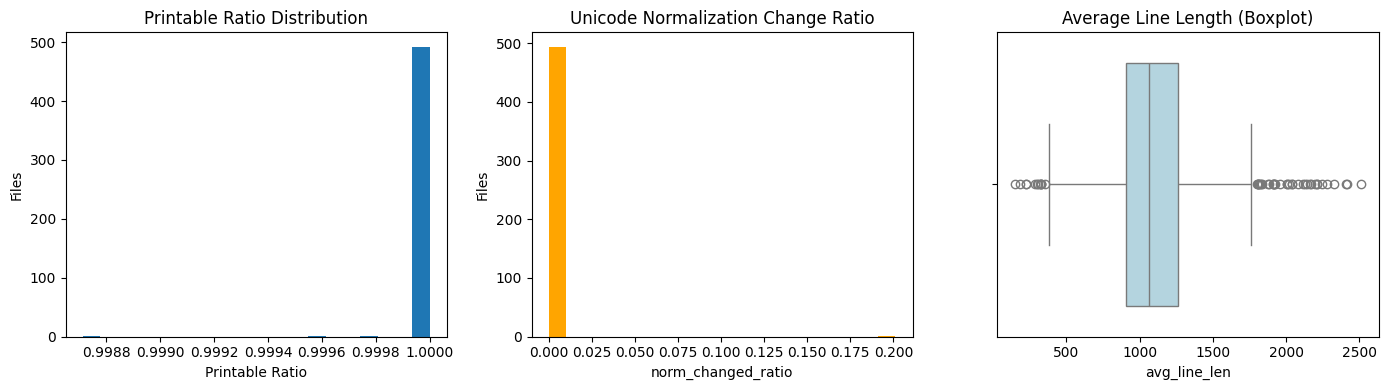

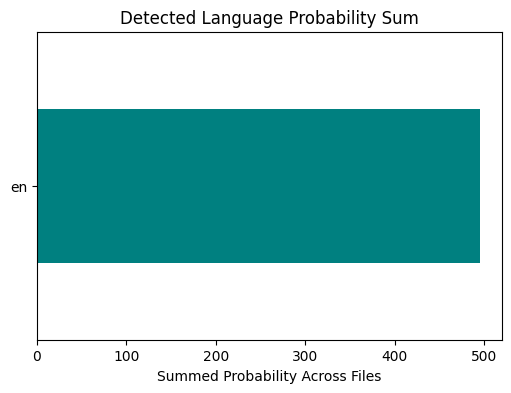

C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\SakuraSnow\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


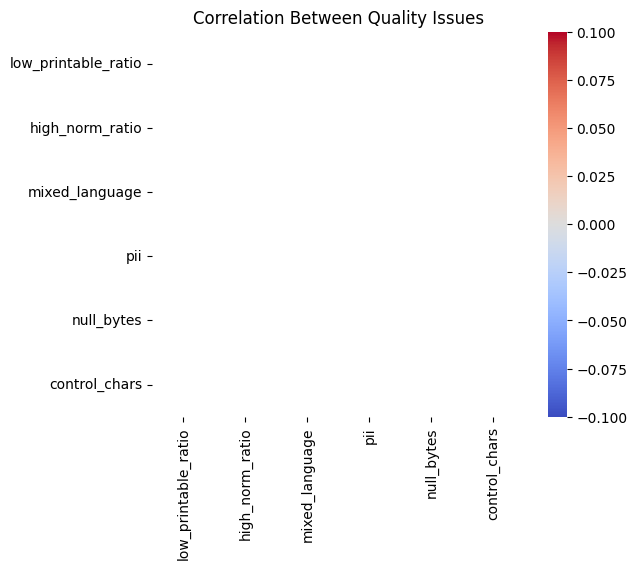


 Data Quality Report generated successfully.

Total files analyzed: 495
Files with potential issues: 0


In [33]:
# Convert the data into a dataFrame
df_clean = pd.DataFrame(data_clean)
generate_quality_report(df_clean)

After cleaning, the dataset shows clear and consistent improvements across all quality metrics, confirming that it is now reliable, structured, and ready for analysis.  

The **Printable Ratio Distribution** is tightly grouped near 1.0, showing that all files contain readable text and that corrupted or binary data have been removed. The **Unicode Normalization Change Ratio** stays near zero, meaning normalization required almost no adjustment and the text is already clean. The **Average Line Length** boxplot shows that most documents are around 1,000 tokens, with few outliers, reflecting a balanced and consistent corpus.  

The **Language Probability Distribution** confirms that the dataset is overwhelmingly English, with only a handful of symbol-only cases labeled as “no language.” Finally, the **Correlation Heatmap** reveals little overlap among quality metrics, indicating that the cleaning process worked effectively and each validation step addressed a distinct aspect of data quality.

Overall, these results demonstrate that the cleaning pipeline worked as intended: the final dataset is clean, standardized, and almost entirely English — well-prepared for downstream analysis or model training with minimal noise or privacy risk.